In [145]:
import pandas as pd
import geopandas as gpd
import osmnx as ox
import shapely
import folium
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
place = "Mexico City, Mexico"
graph = ox.graph_from_place(place, network_type="drive")

In [63]:
nodes, streets = ox.graph_to_gdfs(graph)
streets.head()

osmid  oneway lanes                      name  \
u        v         key                                                      
30339493 274185917 0    226529202    True     4  Calzada San Antonio Abad   
30339495 274187776 0    226529202    True     4  Calzada San Antonio Abad   
         274188569 0    683249554    True     1      Calle Juan A. Mateos   
30339671 275512749 0    396108080   False     4       Calle Matías Romero   
         274840978 0    569407579   False     4       Calle Matías Romero   

                            highway   length  \
u        v         key                         
30339493 274185917 0          trunk  143.775   
30339495 274187776 0          trunk  119.144   
         274188569 0    residential   58.283   
30339671 275512749 0    residential   87.489   
         274840978 0    residential   12.831   

                                                                 geometry  \
u        v         key                                                      
30339493 274185917 0    LINESTRING (-99.13410 19.41806, -99.13409 19.4...   
30339495 274187776 0    LINESTRING (-99.13533 19.41027, -99.13517 19.4...   
         274188569 0    LINESTRING (-99.13533 19.41027, -99.13478 19.4...   
30339671 275512749 0    LINESTRING (-99.15338 19.37858, -99.15256 19.3...   
         274840978 0    LINESTRING (-99.15338 19.37858, -99.15350 19.3...   

                        ref maxspeed width bridge tunnel junction access  
u        v         key                                                    
30339493 274185917 0    NaN      NaN   NaN    NaN    NaN      NaN    NaN  
30339495 274187776 0    NaN      NaN   NaN    NaN    NaN      NaN    NaN  
         274188569 0    NaN      NaN   NaN    NaN    NaN      NaN    NaN  
30339671 275512749 0    NaN      NaN   NaN    NaN    NaN      NaN    NaN  
         274840978 0    NaN      NaN   NaN    NaN    NaN      NaN    NaN

<AxesSubplot:>

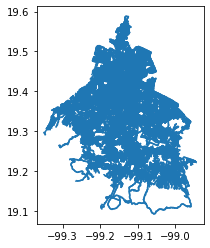

In [4]:
streets.plot()



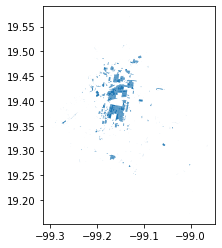

In [151]:
streets= streets[streets.highway.isin(['residential', 'service', 'road'])]
#only certain areas
polygons = shapely.ops.polygonize(streets.geometry)

polygons = gpd.GeoSeries(polygons, crs=4326)

polygons.plot()
pgdf = gpd.GeoDataFrame(geometry=gpd.GeoSeries(polygons))


In [157]:
building = ox.geometries_from_place(place, tags={'building': True, 'landuse': 'commercial', 'amenity':['restaurant', 'cafe','bus_station']})

#building = building.dropna(subset=["parking"])


values=["POINT"]
building = building[building.geometry.isin(values) == False]
#building.head()

/Users/avanitiwari/opt/anaconda3/envs/datascience/lib/python3.8/site-packages/osmnx/geometries.py:805: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  for merged_outer_linestring in list(merged_outer_linestrings):
/Users/avanitiwari/opt/anaconda3/envs/datascience/lib/python3.8/site-packages/osmnx/geometries.py:805: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for merged_outer_linestring in list(merged_outer_linestrings):


In [158]:
building.describe()

/Users/avanitiwari/opt/anaconda3/envs/datascience/lib/python3.8/site-packages/pandas/core/dtypes/cast.py:118: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


,amenity,parking,geometry,name,addr:housenumber,addr:postcode,addr:street,name:en,name:es,operator,...,local_name,cost,ramp:wheelchair,ways,type,subject,url,name:hi,wikipedia:en,building:material_1
count,4613,61,118663,8970,4805,2574,6014,119,202,498,...,1,1,1,644,644,1,1,1,1,2
unique,64,5,118660,6456,1242,333,1464,108,190,238,...,1,1,1,644,1,1,1,1,1,1
top,restaurant,multi-storey,POINT (-99.1148828 19.2665706),Pemex,7,04700,Avenida Panamericana,Starbucks,Starbucks,CCH Sur,...,Banamex Portales,$6,yes,"[27432723, 27432724, 27432725, 27432726, 27457...",multipolygon,Frida Kahlo,http://www.museofridakahlo.org.mx/,राष्ट्रीय महल,Palace of the Inquisition,concrete
freq,2107,44,2,215,49,603,356,7,7,35,...,1,1,1,1,644,1,1,1,1,2


<AxesSubplot:>

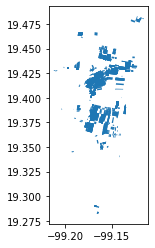

In [159]:
building_points = building.geometry["node"]



buildingdf = gpd.GeoDataFrame(geometry=gpd.GeoSeries(building_points))


#these areas contain the building with max amenities which are important to around's customers 
#the areas are obtained by spatial joining the

areas=gpd.sjoin( pgdf, buildingdf,how= "inner", predicate="intersects")



#plotting areas
areas.plot()




In [160]:
m = folium.Map([19.4326, -99.1332], 
               zoom_start=13, 
               tiles="CartoDB positron")

#marking all the areas in the map using folium 
for _, r in areas.iterrows():
    sim_geo = gpd.GeoSeries(r['geometry']).simplify(tolerance=0.001)
    geo_j = sim_geo.to_json()
    geo_j = folium.GeoJson(data=geo_j,
                           style_function=lambda x: {'fillColor': 'pink'})
    
    geo_j.add_to(m)
m
#below should be a map with ares for listing marked in pink 